<a href="https://colab.research.google.com/github/aquapathos/MLLesson/blob/master/SuperMarioBros.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SuperMarioBros openAI gym 環境などのインストール

- gmy-super-mario-bros
- wandb
- 自作ライブラリ

wandb のアカウントを持っていることが前提です。

In [ ]:
!wget https://raw.githubusercontent.com/aquapathos/MLLesson/master/mksmb_env.py -q
!pip install gym-super-mario-bros > /dev/null
!pip install wandb > /dev/null
!pip install stable-baselines3 > /dev/null

このインストール過程で、[nes-py](https://github.com/Kautenja/nes-py) というファミコンエミュレータがインストールされる模様。

これは

モデルを保存するために Google Drive をマウント

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# 動作確認

In [ ]:
import gym,cv2

import gym_super_mario_bros
from mksmb_env import Joy,make_mario_env,recordModelCallback
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT,COMPLEX_MOVEMENT,RIGHT_ONLY
from stable_baselines3.common.vec_env import DummyVecEnv,SubprocVecEnv,VecFrameStack

env_id = 'SuperMarioBros-v0'
#env = make_mario_env(env_id, n_envs=8, seed=0,vec_env_cls=SubprocVecEnv, monitor_dir= "test")
env = make_mario_env(Joy(), n_envs=4, seed=0,vec_env_cls=DummyVecEnv, monitor_dir= "test")
env = VecFrameStack(env, n_stack=4)

from PIL import Image 
Image.fromarray((env.render(mode='rgb_array')))

スーパーマリオのアクションスペースは256種ものアクションがあり、[JoypadSpace() ](https://github.com/Kautenja/nes-py/blob/master/nes_py/wrappers/joypad_space.py))というラッパーを通すと7種に減ることがわかる。[JoypadSpace() ](https://github.com/Kautenja/nes-py/blob/master/nes_py/wrappers/joypad_space.py)のソースを見ると、

```
    # a mapping of buttons to binary values
    _button_map = {
        'right':  0b10000000,
        'left':   0b01000000,
        'down':   0b00100000,
        'up':     0b00010000,
        'start':  0b00001000,
        'select': 0b00000100,
        'B':      0b00000010,
        'A':      0b00000001,
        'NOOP':   0b00000000,
    }
```
とあり、

```
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
```

は、[actions.py](https://github.com/Kautenja/gym-super-mario-bros/blob/1a3dde897700614f729fc3294c1e451528d9a112/gym_super_mario_bros/actions.py)で、

```
# actions for very simple movement
SIMPLE_MOVEMENT = [
    ['NOOP'],
    ['right'],
    ['right', 'A'],
    ['right', 'B'],
    ['right', 'A', 'B'],
    ['A'],
    ['left'],
]
```
と定義されている。基本的にスーパーマリオは右スクロールのゲームなので、これでもよさげだが、左ジャンプぐらいもやはりほしい。upは NOOPと同じなので省いて、次のアクションスペースを使ってみる。

In [ ]:
MYACTIONSET = [
    ['NOOP'],
    ['right'],
    ['right', 'A'],
    ['right', 'B'],
    ['right', 'A', 'B'],
    ['A'],
    ['left'],
    ['left', 'A'],
]

ゲーム画面のサイズは

In [ ]:
gym_super_mario_bros.make('SuperMarioBros-v0').reset().shape

(240, 256, 3)

# PPO学習

In [ ]:
from stable_baselines3.common.vec_env import DummyVecEnv,SubprocVecEnv,VecFrameStack,VecEnv
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback
import wandb,os
import numpy as np
import torch,gym
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(repr(device))

device(type='cpu')


Stable Baselines3 のMonitor()ラッパーで、エピソードごとの報酬がcsv 形式で保存される。また、公式ページのコールバック関数を使うと、直近100エピソードの平均報酬の最大値を、tensorboard用のログ形式で保存される。

さらに、マリオ環境は、infoにコイン数、スコア、時間、座標を出力しているので、それらを WandB のログとして残すようにプログラムした。 

wandb 

<img width="483" alt="loggraph" src="https://user-images.githubusercontent.com/5820803/104266956-fe869e80-54d3-11eb-922f-6857a629d1b9.png">

In [ ]:
log_dir ='/content/drive/MyDrive/M/smb'

# Inside my model training code 
!export WANDB_NOTEBOOK_NAME="Mario".ipynb"
import wandb
PROJECTNAME='Mario'
wandb.init(project=PROJECTNAME)

# 学習プログラム

In [ ]:
from stable_baselines3.common.evaluation import evaluate_policy

def ev(lr):
    monargs={'usewandb':True}
    #env = make_mario_env(Joy(movement=MYACTIONSET), n_envs=8, seed=0,vec_env_cls=SubprocVecEnv, monitor_dir=log_dir,monitor_kwargs=monargs)
    env = make_mario_env(Joy(movement=MYACTIONSET), n_envs=8, seed=0,vec_env_cls=DummyVecEnv, monitor_dir= log_dir,monitor_kwargs=monargs)
    env = VecFrameStack(env, n_stack=4)

    model = PPO('CnnPolicy', env, verbose=0,device=device,        
        learning_rate = lr,  # default  3e-4
        gamma = 0.9,
        n_steps = 1024, # 2048
        clip_range = 0.2, # default 0.2
        ent_coef = 0.01, # default 0.01
        batch_size = 128, #64
        n_epochs = 4 ) # 4

    # model.load('/content/drive/MyDrive/M/smb/best_model.zip')
    callback = recordModelCallback(check_freq=50, log_dir=log_dir, usewandb=True)
    total_timesteps = 2e7
    %time model.learn(total_timesteps=total_timesteps,callback=callback)


学習の実行

In [ ]:
#!rm /content/drive/MyDrive/M/smb/?.moni*

In [ ]:
ev(3.e-4)

# 動画化

### フレーム収集

In [ ]:
env = make_mario_env(Joy(movement=MYACTIONSET), n_envs=1, seed=0,vec_env_cls=DummyVecEnv)
env = VecFrameStack(env, n_stack=4)
log_dir ='/content/drive/MyDrive/M/smb'
model = PPO('CnnPolicy',env)
model = PPO.load(log_dir+"/best_model.zip")

In [ ]:
width,height = 256,240
images = []
obs = env.reset()
img = cv2.resize(env.render(mode='rgb_array'),(width,height))
for i in range(900):
    images.append(img)
    action, _ = model.predict(obs)
    obs, _, _ ,_ = env.step(action)
    img = cv2.resize(env.render(mode='rgb_array'),(width,height))


### GIF動画化

In [ ]:
import imageio
imageio.mimsave('smb.gif', [np.array(img) for i, img in enumerate(images) if i%2 == 0], fps=29)

### mp4

In [ ]:
frame_rate = 30.0  #FPS
def timelaps(images,width,height):
    fourcc = cv2.VideoWriter_fourcc('m','p','4','v')
    video = cv2.VideoWriter('smb.mp4', fourcc, frame_rate, (width, height))
    for img in images:
        video.write(img[:,:,::-1]) 
    video.release()
timelaps(images,width=width,height=height)

### 高得点ケースの録画

In [ ]:
env = make_mario_env(Joy(movement=MYACTIONSET), n_envs=1, seed=0,vec_env_cls=DummyVecEnv)
env = VecFrameStack(env, n_stack=4)
width,height = 256,240
while True:
  images = []
  obs = env.reset()
  img = cv2.resize(env.render(mode='rgb_array'),(width,height))
  images.append(img)
  complete = False
  while not complete:
    action, _ = model.predict(obs)
    obs, _, done ,info = env.step(action)
    img = cv2.resize(env.render(mode='rgb_array'),(width,height))
    images.append(img)
    if done:
      print(info[0]['x_pos'])
      if info[0]['x_pos'] > 2500:
          complete = True
  if complete:
    break

In [ ]:
len(images)

1305

In [ ]:
info

[{'coins': 0,
  'flag_get': False,
  'life': 1,
  'score': 400,
  'stage': 1,
  'status': 'small',
  'time': 400,
  'world': 1,
  'x_pos': 1319,
  'y_pos': 79}]

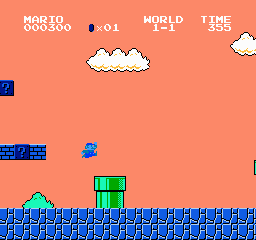

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(env.render(mode='rgb_array')[::])